In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import config
import sklearn
from sklearn import metrics
from tqdm import tqdm
import config
import designimg as d

error creating /home/asajw/resized_images_seti/256256
folder exists, make sure this call is from inference.py


In [2]:
oof_path = f'/home/asajw/SETI/output/efficientnet_b0_dt0604/oof_df_efficientnet_b0_bs32_size256_dt0604.csv'

In [3]:
oof = pd.read_csv(oof_path)
oof.head()

,predictions,targets,target_ids
0,0.001129,0.0,28093
1,0.000970,0.0,36847
2,0.000214,0.0,46850
3,0.000142,0.0,45410
4,0.000538,0.0,9789


In [4]:
oof.targets.value_counts()

0.0    45471
1.0     4694
Name: targets, dtype: int64

In [5]:
# defining tp, tn, fp, fn from basic

class Metrics():
    def __init__(self, ytrue, ypred):
        self.ytrue = ytrue
        self.ypred = ypred
        
    def true_pos(self):
        tp = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 1 and yp == 1:
                tp += 1
        return tp

    def true_neg(self):
        tn = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 0 and yp == 0:
                tn += 1
        return tn

    def false_pos(self):
        fp = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 0 and yp == 1:
                fp += 1
        return fp

    def false_neg(self):
        fn = 0
        for yt, yp in zip(self.ytrue, self.ypred):
            if yt == 1 and yp == 0:
                fn += 1
        return fn

    def precision(self):
        tp = self.true_pos()
        fp = self.false_pos()
        return tp / (tp + fp)

    def recall(self):
        tp = self.true_pos()
        fn = self.false_neg()  
        return tp / (tp + fn)
    
    def f1(self):
        p = self.precision()
        r = self.recall()
        return 2*p*r / (p +r)
    
    def tpr(self):
        return self.recall()
    
    def fpr(self):
        fp = self.false_pos()
        tn = self.true_neg()
        return fp / (fp + tn)
    
    def roc_auc(self):
        return metrics.roc_auc_score(self.ytrue, self.ypred)
    
    

In [6]:
thresholds = [x/1000 for x in range(1000)]

In [7]:
mDF = pd.DataFrame({
                    'threshold':[],
                    'fp':[], 'fn':[], 'tn':[], 'tp':[],
                    'precision':[], 'recall':[],
                    'tpr':[], 'fpr':[],
                    'f1':[], 'roc_threshold':[],
                    })


In [8]:
for i, threshold in tqdm(enumerate(thresholds)):
    ypred = oof['predictions'].values.tolist()
    ypred = [1 if y > threshold else 0 for y in ypred]
    ytrue = oof['targets'].values.tolist()
    m = Metrics(ytrue, ypred)
    mDF.loc[i, 'threshold'] = threshold
    mDF.loc[i, 'fp'] = m.false_pos()
    mDF.loc[i,'fn'] = m.false_neg()
    mDF.loc[i,'tp'] = m.true_pos()
    mDF.loc[i,'tn'] = m.true_neg()
    mDF.loc[i,'precision'] = m.precision()
    mDF.loc[i,'recall'] = m.recall()
    mDF.loc[i,'tpr'] = m.tpr()
    mDF.loc[i,'fpr'] = m.fpr()
    mDF.loc[i,'f1'] = m.f1()
    mDF.loc[i,'roc_threshold'] = m.roc_auc()

1000it [01:12, 13.86it/s]


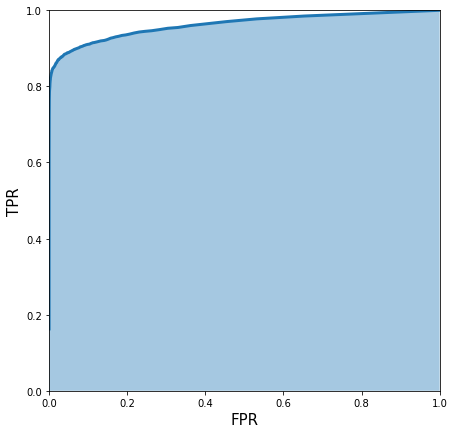

In [9]:
plt.figure(figsize=(7,7))
plt.fill_between(mDF['fpr'].values.tolist(), mDF['tpr'].values.tolist(), alpha = 0.4)
plt.plot(mDF['fpr'].values.tolist(), mDF['tpr'].values.tolist(), lw = 3)
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('FPR', fontsize = 15)
plt.ylabel('TPR', fontsize = 15)
plt.show()

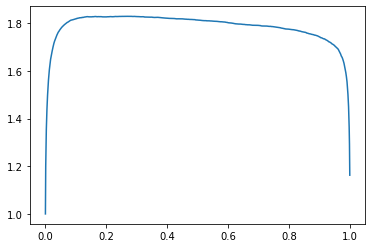

In [10]:
mDF['sweet_spot'] = (mDF['tpr']+1)/( mDF['fpr'] + 1)
plt.plot(mDF['threshold'], mDF['sweet_spot'])
plt.show()

In [11]:
mDF.query('threshold >0.8 and threshold < 0.86').head()

,threshold,fp,fn,tn,tp,precision,recall,tpr,fpr,f1,roc_threshold,sweet_spot
801,0.801,34.0,1049.0,45437.0,3645.0,0.990758,0.776523,0.776523,0.000748,0.870656,0.887888,1.775196
802,0.802,34.0,1050.0,45437.0,3644.0,0.990756,0.776310,0.776310,0.000748,0.870521,0.887781,1.774983
803,0.803,34.0,1051.0,45437.0,3643.0,0.990753,0.776097,0.776097,0.000748,0.870386,0.887675,1.774770
804,0.804,34.0,1052.0,45437.0,3642.0,0.990751,0.775884,0.775884,0.000748,0.870251,0.887568,1.774557
805,0.805,33.0,1053.0,45438.0,3641.0,0.991018,0.775671,0.775671,0.000726,0.870220,0.887473,1.774383


In [12]:
threshold_fp = 0.82 #to identify the real fp set it high
oof['predictions_bool_fp'] = oof['predictions'].apply(lambda x : 0 if x < threshold_fp else 1)  
oof['fp'] = oof.apply(lambda x: Metrics([x['targets']],
                                        [x['predictions_bool_fp']]).false_pos(), axis = 1) 
threshold_fn = 0.20 # to identify the real fn set it low
oof['predictions_bool_fn'] = oof['predictions'].apply(lambda x : 0 if x < threshold_fn else 1)  
oof['fn'] = oof.apply(lambda x: Metrics([x['targets']],
                                        [x['predictions_bool_fn']]).false_neg(), axis = 1)

In [13]:
oof.query('fp == 1').head()

,predictions,targets,target_ids,predictions_bool_fp,fp,predictions_bool_fn,fn
850,0.871072,0.0,5908,1,1,1,0
1230,0.901952,0.0,32297,1,1,1,0
1264,0.978067,0.0,4185,1,1,1,0
2175,0.973091,0.0,27097,1,1,1,0
2758,0.829916,0.0,21606,1,1,1,0


In [14]:
tr = pd.read_csv(f'{config.DATA_PATH}train_labels.csv')
trfp = tr[tr.index.isin(oof.query('fp == 1')['target_ids'].values.tolist())]
trfn = tr[tr.index.isin(oof.query('fn == 1')['target_ids'].values.tolist())]

In [15]:
# negative images classified as positive (fp)
print(trfp.head(), '\n\n', trfn.head())

                 id  target
2137   0af617bfe9c7       0
4185   150be16760e4       0
5908   1df8465e6de7       0
10234  34228c45c196       0
12058  3d601f7599e5       0 

                id  target
34   003147674cb9       1
76   00667e94a985       1
85   0078157399c9       1
148  00ca1a44f310       1
211  011184c5f640       1


In [16]:
def disp_image(image_path):
    img = np.load(image_path)
    plt.imshow(img)
    plt.show()

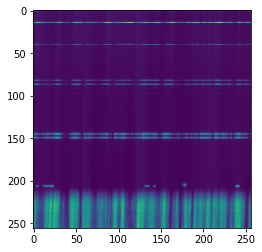

In [17]:
#images classified as positive but aren't
pos_imgs = trfp.id.values
for i in pos_imgs[0:1]:
    disp_image(f'{config.RESIZED_IMAGE_PATH}train/{i}.npy')

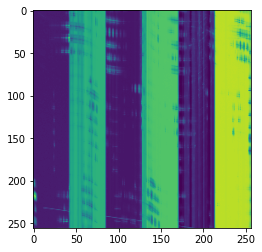

In [18]:
#images classified as negative but are positive 
pos_imgs = trfn.id.values
for i in pos_imgs[0:1]:
    disp_image(f'{config.RESIZED_IMAGE_PATH}train/{i}.npy')

In [25]:
trl = pd.read_csv(f'{config.DATA_PATH}train_labels.csv')
trlp = trl[trl['target'] == 1]
trln = trl[trl['target'] == 0]
trln.query(f'''id == '150be16760e4' ''')

,id,target
4185,150be16760e4,0


003147674cb9


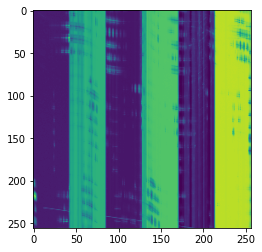

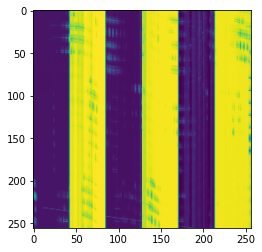

00667e94a985


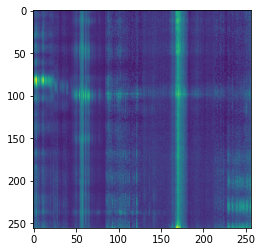

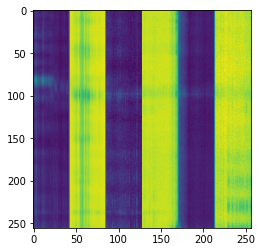

0078157399c9


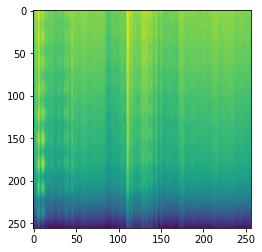

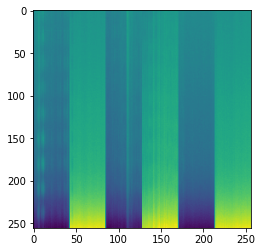

00ca1a44f310


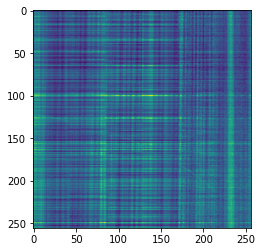

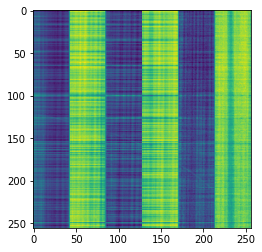

011184c5f640


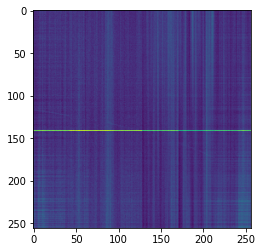

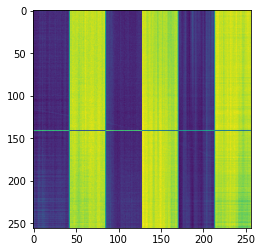

0216000821a3


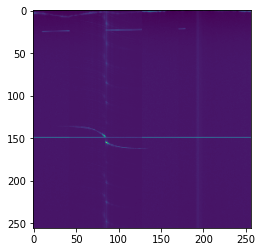

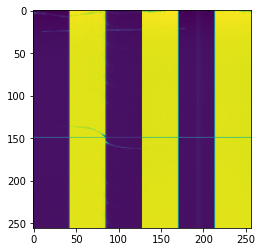

025a8396f9db


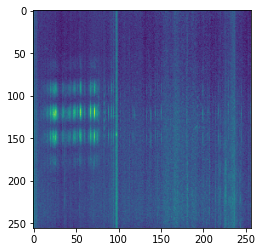

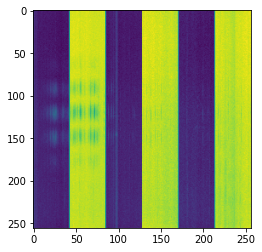

02616cd942c6


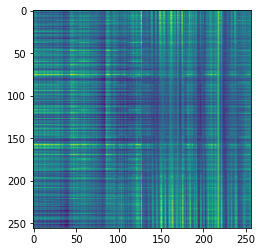

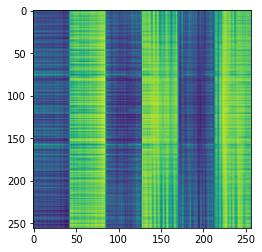

027f83ec7a6f


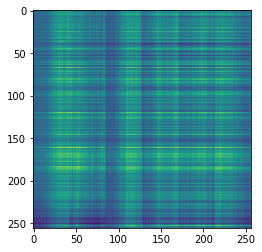

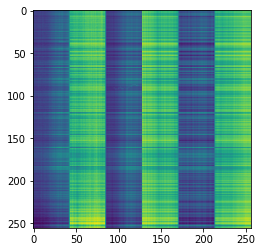

03012c5c944c


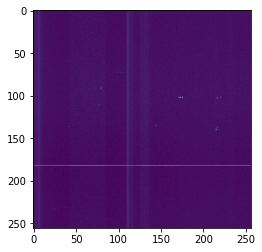

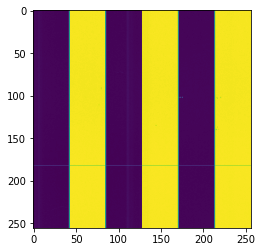

In [20]:
#see inverted positive images classified as negative
pos_imgs = trfn.id.values
pos_inv_imgs = []
for i in pos_imgs[0:10]:
    im = d.DesignImage(images_set = 'train')
    img = im.simple_concat(image_path = f'{config.DATA_PATH}{im.images_set}/{i[0]}/{i}.npy' )
    print(i)
    disp_image(f'{config.RESIZED_IMAGE_PATH}train/{i}.npy')
    pos_inv_imgs.append(img)
    plt.imshow(img)
    plt.show()

0af617bfe9c7


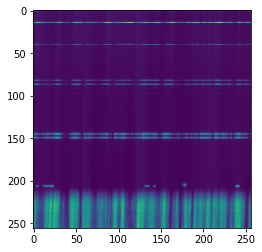

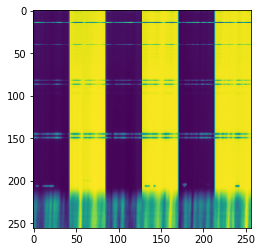

150be16760e4


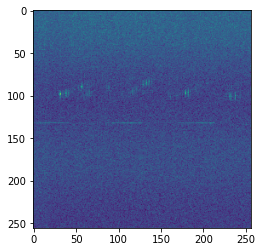

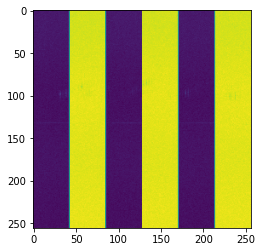

1df8465e6de7


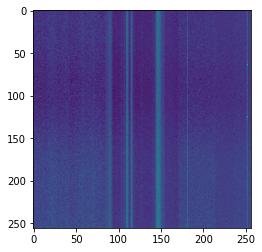

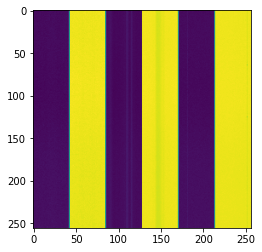

34228c45c196


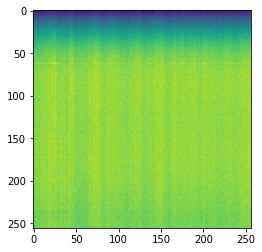

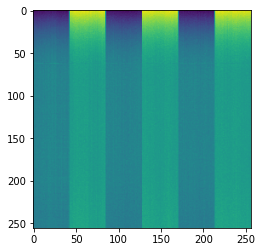

3d601f7599e5


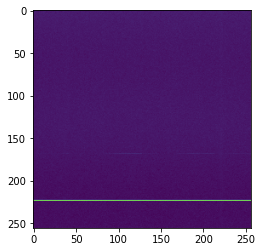

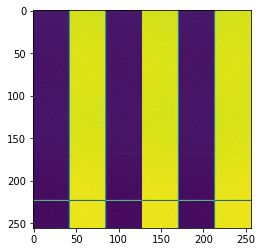

4152cb9dec73


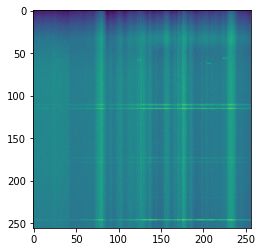

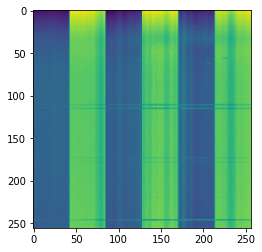

537946cb4edc


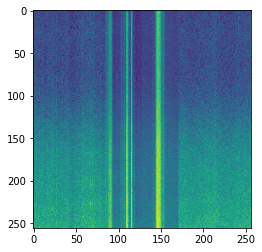

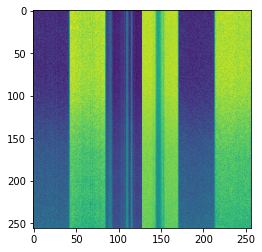

54bba22a196b


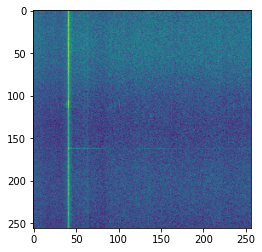

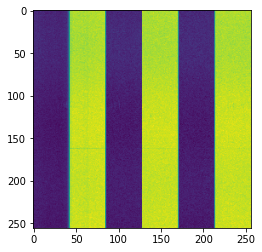

54bcef0ffa92


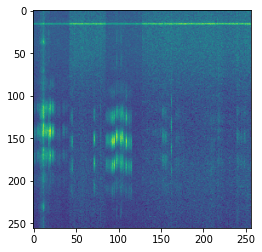

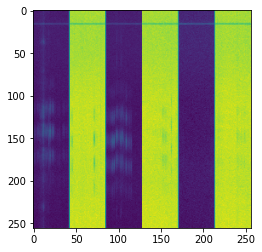

68c6156f0dbd


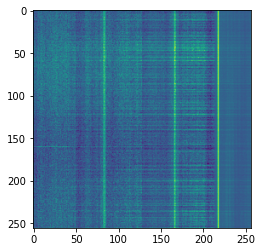

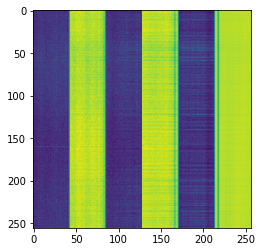

In [23]:
#see inverted negative images classified as positive
neg_imgs = trfp.id.values
neg_inv_imgs = []
for i in neg_imgs[0:10]:
    im = d.DesignImage(images_set = 'train')
    img = im.simple_concat(image_path = f'{config.DATA_PATH}{im.images_set}/{i[0]}/{i}.npy' )
    print(i)
    disp_image(f'{config.RESIZED_IMAGE_PATH}train/{i}.npy')
    pos_inv_imgs.append(img)
    plt.imshow(img)
    plt.show()